In [1]:
import seaborn as sns
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

from matplotlib import pyplot as plt

import random
from collections import defaultdict

%matplotlib inline

In [2]:
DATA_DIR = "~/jupyter_notebooks/DATA/MarchMadness"

In [3]:
YEAR = 2018
raw_tournament_df = pd.read_csv(f"{DATA_DIR}/output/teams.csv")
tournament_df = raw_tournament_df[raw_tournament_df["Season"] == YEAR]
tournament_df

,TeamID,TeamName,Season,OwnScore_Zscore,OppScore_Zscore,Dominance,OffCompetition,DefCompetition,Competition,AdjOffense,AdjDefense,Seed,SeedInt,Wins
22,1104,Alabama,2018,0.011903,-0.330271,0.342174,0.084649,-0.079049,0.163697,1.870712,3.723368,W09,9,1.0
70,1112,Arizona,2018,0.563319,-0.246216,0.809535,0.066633,-0.042342,0.108976,4.928210,2.469381,Y04,4,0.0
76,1113,Arizona St,2018,0.859063,0.256554,0.602508,0.068189,-0.045074,0.113263,6.793374,-0.603367,X11a,11,0.0
103,1116,Arkansas,2018,0.765417,0.120444,0.644973,0.090459,-0.085344,0.175803,6.659980,1.045384,W07,7,0.0
112,1120,Auburn,2018,0.960809,0.015437,0.945372,0.062418,-0.069015,0.131433,7.308376,1.373252,X04,4,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2124,1439,Virginia Tech,2018,0.587977,-0.003500,0.591477,0.055946,-0.066280,0.122227,4.866463,1.436558,W08,8,0.0
2193,1452,West Virginia,2018,0.653570,-0.332100,0.985670,0.088295,-0.068154,0.156448,5.922931,3.517719,W05,5,2.0
2213,1455,Wichita St,2018,0.953512,-0.094535,1.048047,0.023659,-0.049201,0.072860,6.484642,1.662574,W04,4,0.0
2253,1460,Wright St,2018,-0.253708,-0.523239,0.269531,-0.033706,0.036685,-0.070391,-2.153540,2.618226,Y14,14,0.0


In [4]:
# https://www.kaggle.com/c/ncaam-march-mania-2021/data
# Get slots, and order with play ins first
slots_df = pd.read_csv(f"{DATA_DIR}/MNCAATourneySlots.csv")
slots_df = slots_df[slots_df["Season"] == YEAR]
slots_df = pd.concat([
    slots_df[~slots_df["Slot"].str.startswith("R")],
    slots_df[slots_df["Slot"].str.startswith("R")]
])
slots_df

,Season,Slot,StrongSeed,WeakSeed
2180,2018,W11,W11a,W11b
2181,2018,W16,W16a,W16b
2182,2018,X11,X11a,X11b
2183,2018,Z16,Z16a,Z16b
2117,2018,R1W1,W01,W16
...,...,...,...,...
2175,2018,R4Y1,R3Y1,R3Y2
2176,2018,R4Z1,R3Z1,R3Z2
2177,2018,R5WX,R4W1,R4X1
2178,2018,R5YZ,R4Y1,R4Z1


In [5]:
games_df = pd.read_csv(f"{DATA_DIR}/output/games_training.csv")
games_df

,Season,TeamID_A,TeamID_B,OwnScore_Zscore_A,OppScore_Zscore_A,OffCompetition_A,DefCompetition_A,AdjOffense_A,AdjDefense_A,OwnScore_Zscore_B,OppScore_Zscore_B,OffCompetition_B,DefCompetition_B,AdjOffense_B,AdjDefense_B,Win_A
0,1985,1228,1328,-0.170650,-1.122919,0.071527,-0.070089,0.475153,8.475028,1.632782,0.530574,0.074592,-0.030607,11.719832,-2.595899,True
1,1985,1228,1328,-0.170650,-1.122919,0.071527,-0.070089,0.475153,8.475028,1.632782,0.530574,0.074592,-0.030607,11.719832,-2.595899,True
2,1985,1242,1328,0.428736,-0.163805,0.075843,-0.034858,4.278642,1.807709,1.632782,0.530574,0.074592,-0.030607,11.719832,-2.595899,True
3,1985,1328,1374,1.632782,0.530574,0.074592,-0.030607,11.719832,-2.595899,0.522222,-0.193731,0.039361,-0.027919,4.125597,1.855630,False
4,1985,1328,1409,1.632782,0.530574,0.074592,-0.030607,11.719832,-2.595899,0.660810,0.046198,0.066972,-0.009949,5.539549,0.005346,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
166875,2020,1460,1464,0.580601,0.198484,-0.033763,0.061707,3.018873,-2.369212,-0.105439,0.096059,-0.026838,0.058533,-1.096179,-1.668915,False
166876,2020,1227,1460,-0.313002,-0.164300,-0.023355,0.048164,-2.313324,0.157028,0.580601,0.198484,-0.033763,0.061707,3.018873,-2.369212,True
166877,2020,1227,1460,-0.313002,-0.164300,-0.023355,0.048164,-2.313324,0.157028,0.580601,0.198484,-0.033763,0.061707,3.018873,-2.369212,True
166878,2020,1232,1460,0.095964,-0.190164,-0.009144,-0.020654,0.508117,1.688731,0.580601,0.198484,-0.033763,0.061707,3.018873,-2.369212,True


In [6]:
# Train predictor based on derived quality metrics
predict_df = games_df[[
    "AdjOffense_A", "AdjOffense_B",
    "AdjDefense_A", "AdjDefense_B",
]]

scaler = StandardScaler()
data_scaled = pd.DataFrame(
    scaler.fit_transform(predict_df),
    columns=predict_df.columns
) 

reg = LogisticRegression().fit(
    data_scaled,
    games_df[["Win_A"]]
)
reg.score(
    data_scaled,
    games_df[["Win_A"]]
), reg.coef_

/Users/jameswhedbee/miniforge3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


(0.7493048897411313,
 array([[ 1.18549676, -1.14283382,  1.07863803, -1.10548234]]))

In [7]:
# See p-values for model
import statsmodels.api as sm
logit_model=sm.Logit(
    games_df[["Win_A"]].astype(int),
    data_scaled,
)
result=logit_model.fit()
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.497375
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                  Win_A   No. Observations:               166880
Model:                          Logit   Df Residuals:                   166876
Method:                           MLE   Df Model:                            3
Date:                Sun, 14 Mar 2021   Pseudo R-squ.:                  0.2822
Time:                        12:06:29   Log-Likelihood:                -83002.
converged:                       True   LL-Null:                   -1.1563e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
AdjOffense_A     1.1851      0.008    151.554      0.000       1.170       1.200
AdjOffense_B    -1.1414

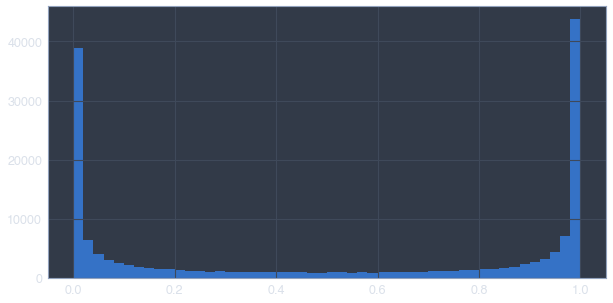

In [8]:
# Sanity check probability distribution
plt.figure(figsize=(10,5));
probs = [
    a for a, b in reg.predict_proba(predict_df)
]
plt.hist(probs, bins=50);

In [9]:
average_team = raw_tournament_df.mean().to_dict()
average_team

{'TeamID': 1291.6819772528434,
 'Season': 2002.2200349956256,
 'OwnScore_Zscore': 0.3844055781106282,
 'OppScore_Zscore': -0.3066529675474941,
 'Dominance': 0.6910585456581223,
 'OffCompetition': 0.03172488205590413,
 'DefCompetition': -0.030439737600443127,
 'Competition': 0.06216461965634727,
 'AdjOffense': 3.1176146536692997,
 'AdjDefense': 2.608194306582973,
 'SeedInt': 8.615048118985127,
 'Wins': 0.9645669291338582}

In [10]:
from functools import lru_cache

@lru_cache(maxsize=4096)
def calc_prob(predict_data):
    return reg.predict_proba(scaler.transform([predict_data]))[0][1]

def get_power_rating(team):
    return calc_prob((
            team["AdjOffense"], average_team["AdjOffense"],
            team["AdjDefense"], average_team["AdjDefense"],
        ))

In [11]:
def scatter_text(x, y, labelseries, labelsize='large', labelcolor='black', **kwargs):
    """Scatter plot with country codes on the x y coordinates
       Based on this answer: https://stackoverflow.com/a/54789170/2641825"""
    # Create the scatter plot
    p1 = sns.scatterplot(x=x, y=y, **kwargs)
    # Add text besides each point
    offset = 0.01 * (max(x) - min(x))
    for line in range(len(x)):
         p1.text(
             x.iloc[line]+offset, y.iloc[line], 
             labelseries.iloc[line], size=labelsize, color=labelcolor
         )
    return p1

In [12]:
# Best teams of all time
raw_tournament_df["PowerRating"] = raw_tournament_df.apply(get_power_rating, axis=1)
raw_tournament_df["PowerOdds"] = raw_tournament_df["PowerRating"] / (1-raw_tournament_df["PowerRating"])
raw_tournament_df["PowerLogOdds"] = np.log(raw_tournament_df["PowerOdds"])

raw_tournament_df.sort_values(by="PowerRating", ascending=False)[[
    "Season", "TeamName", "Seed", "PowerRating", "AdjOffense", "AdjDefense", "Wins"
]][:25]

,Season,TeamName,Seed,PowerRating,AdjOffense,AdjDefense,Wins
419,1999,Duke,W01,0.961315,12.380559,2.898834,5.0
838,2015,Kentucky,Y01,0.957564,6.196966,8.957689,4.0
421,2001,Duke,W01,0.956661,11.802040,3.133246,6.0
418,1998,Duke,Z01,0.955300,8.676690,6.245403,3.0
1973,1991,UNLV,Z01,0.948297,11.355929,3.028745,4.0
612,2019,Gonzaga,X01,0.941308,9.426596,4.602970,3.0
822,1997,Kentucky,Z01,0.940007,8.625912,5.354632,5.0
321,1996,Connecticut,Y01,0.938664,7.680736,6.253925,2.0
1284,1998,North Carolina,W01,0.937336,8.663415,5.175158,4.0
769,1997,Kansas,X01,0.935930,9.885463,3.847875,2.0


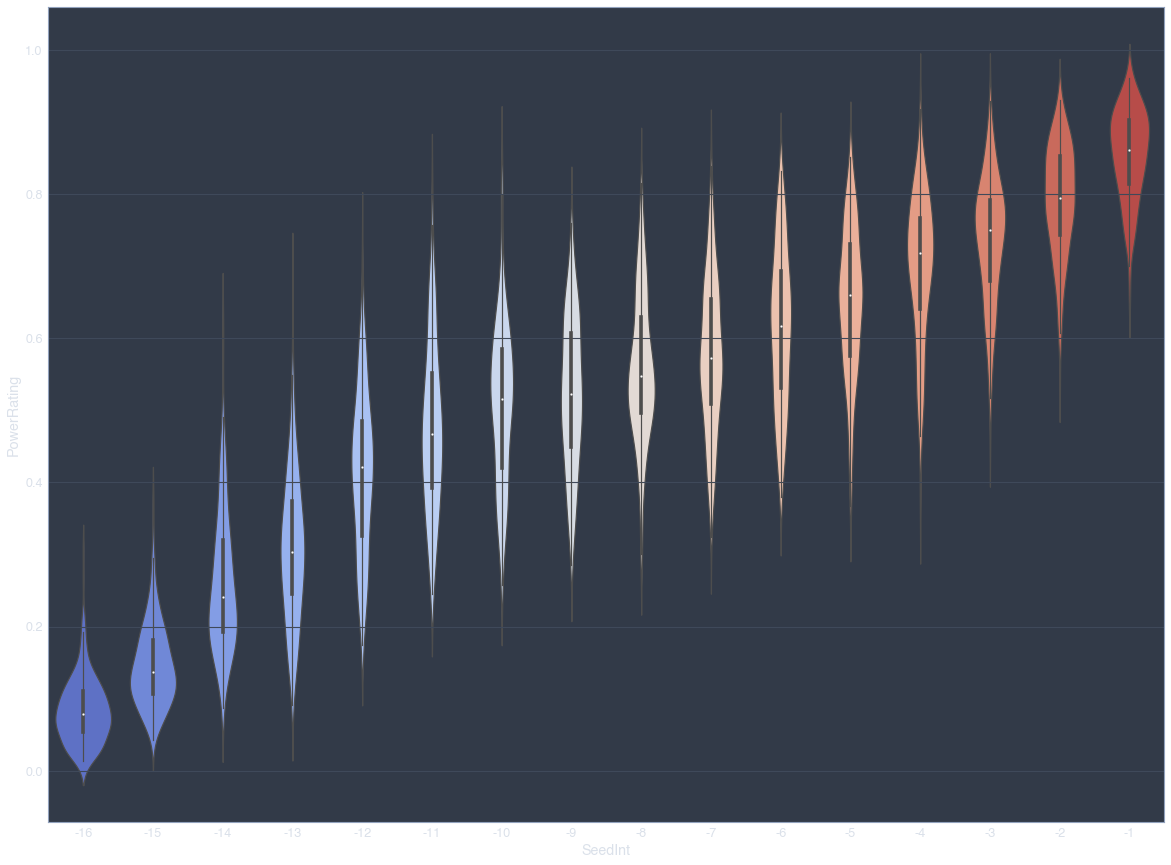

In [13]:
plt.figure(figsize=(20,15));
sns.violinplot(
    x=-raw_tournament_df["SeedInt"],
    y=raw_tournament_df["PowerRating"],
    palette="coolwarm",
);

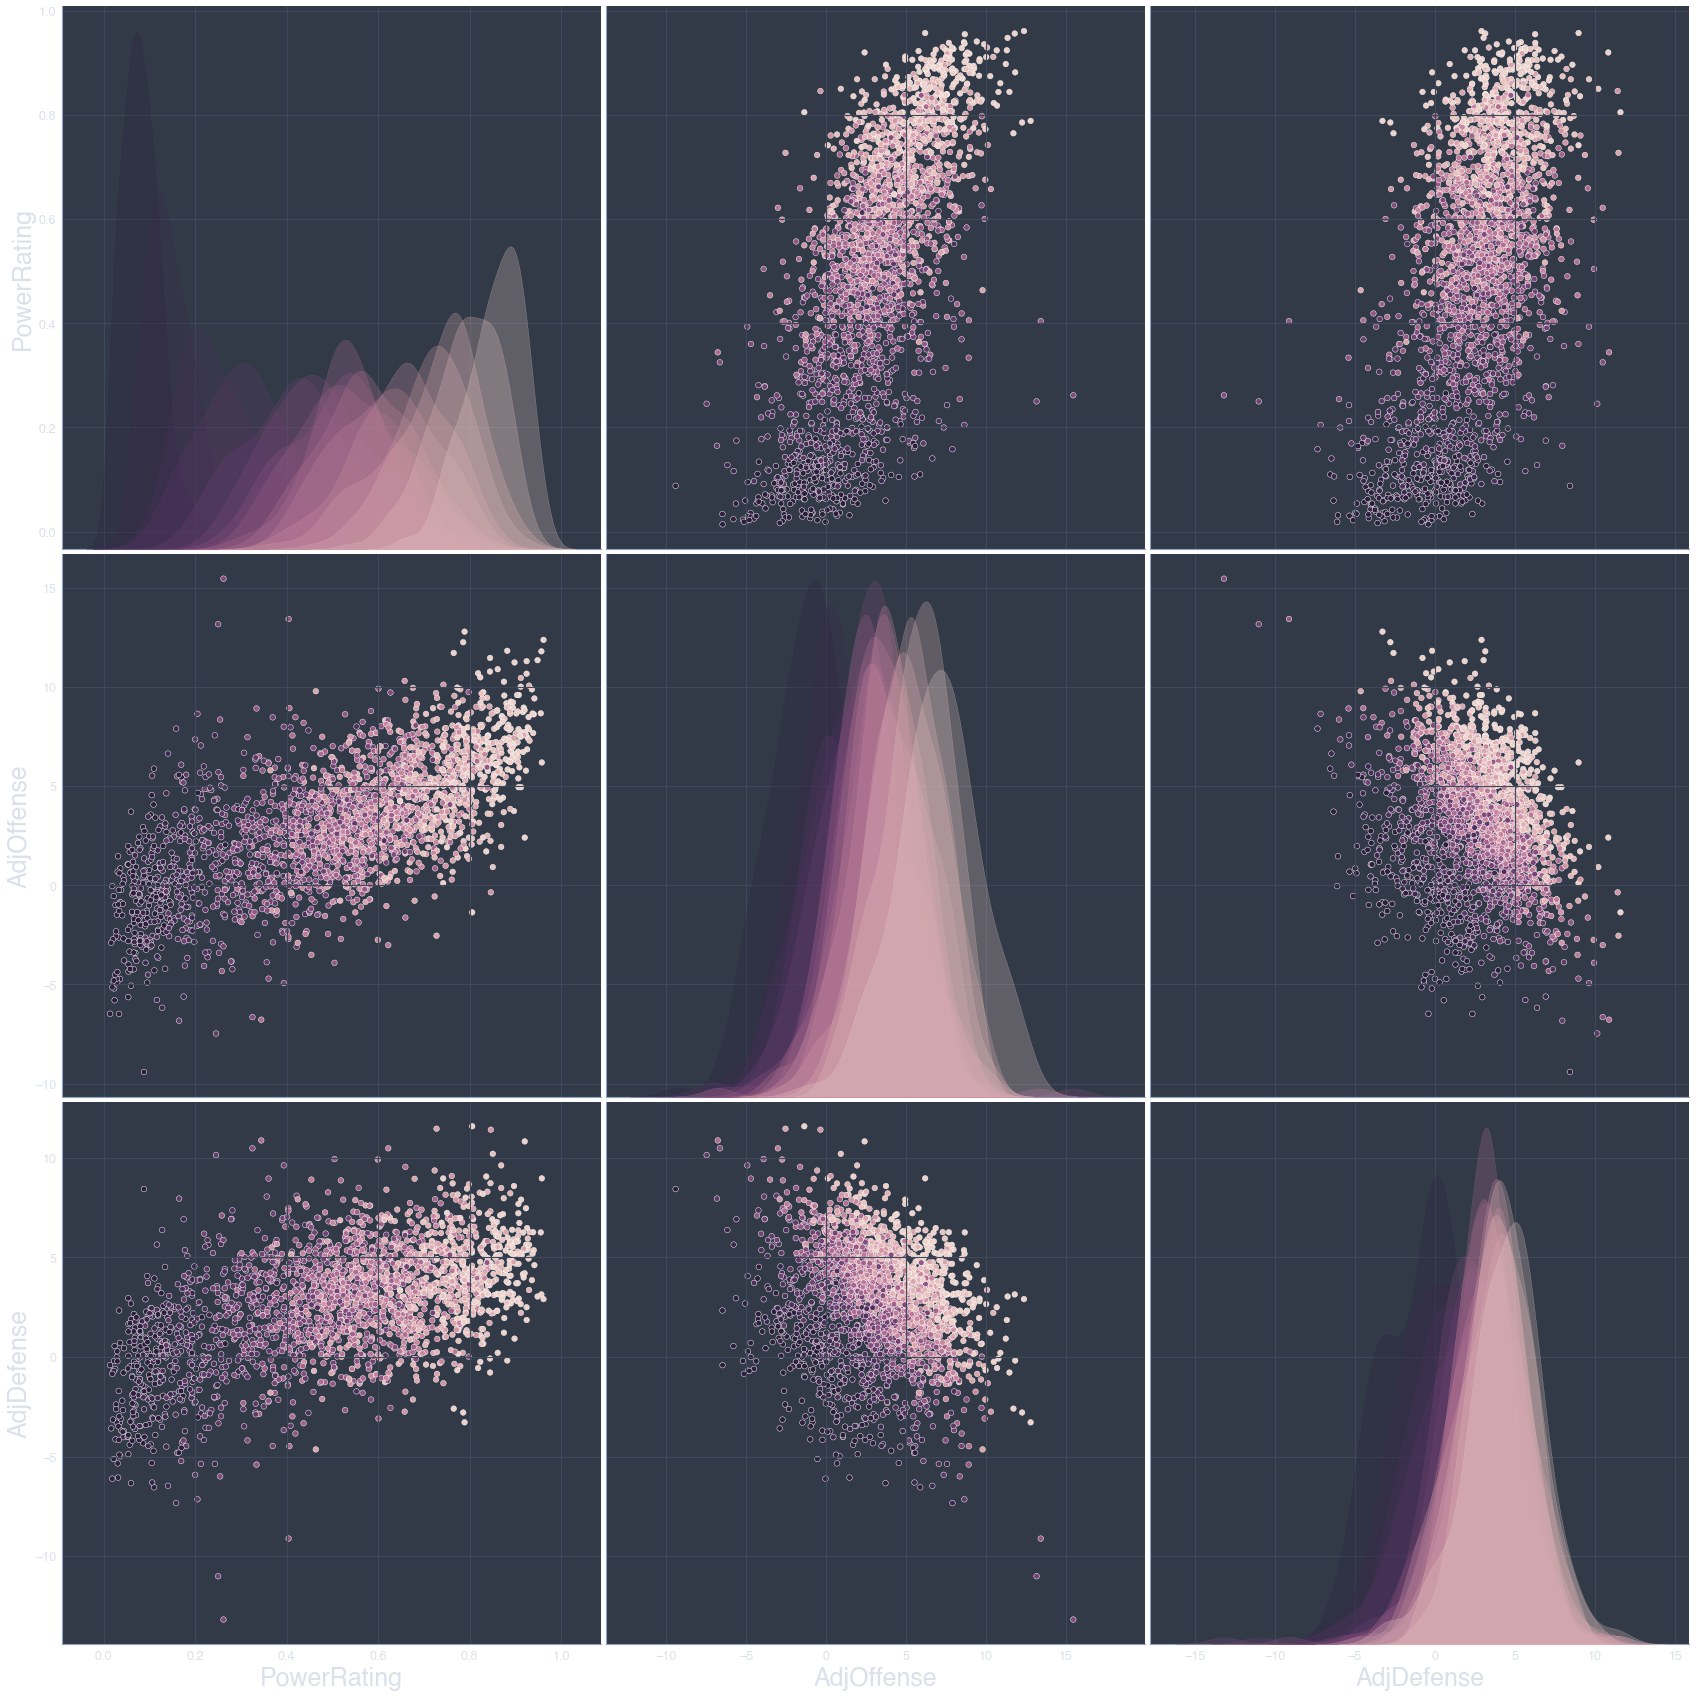

In [14]:
with sns.plotting_context():
    plt.rc('axes', labelsize=25);
    g = sns.pairplot(
        raw_tournament_df[["PowerRating", "AdjOffense", "AdjDefense", "SeedInt"]],
        hue="SeedInt", height=8
    );
    g._legend.remove();

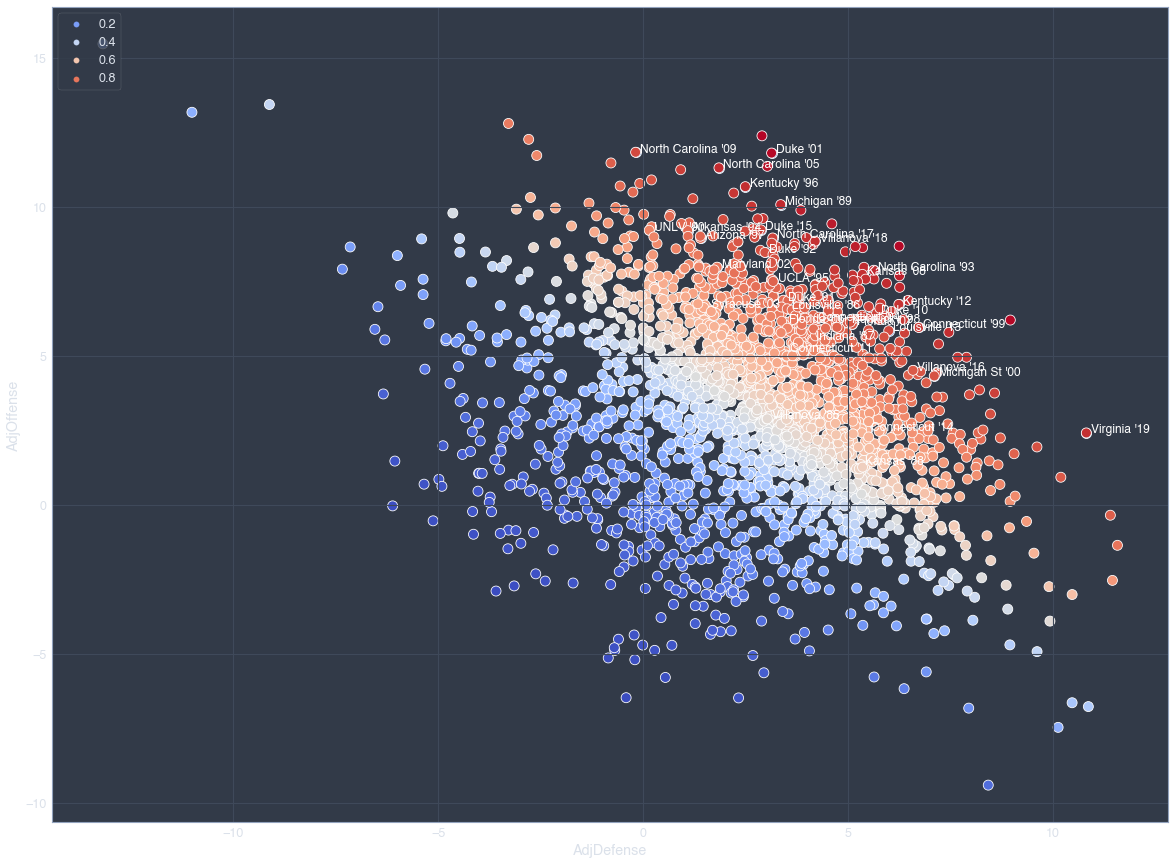

In [15]:
plt.figure(figsize=(20,15));
is_champion = raw_tournament_df["Wins"] >= 6
label_series = (
    raw_tournament_df[is_champion]["TeamName"] + " '" +
    raw_tournament_df[is_champion]["Season"].astype(str).str[-2:]
)
scatter_text(
    x=raw_tournament_df[is_champion]["AdjDefense"],
    y=raw_tournament_df[is_champion]["AdjOffense"],
    labelseries=label_series,
    labelcolor="white",
    s=100,
);
sns.scatterplot(
    x=raw_tournament_df["AdjDefense"],
    y=raw_tournament_df["AdjOffense"],
    hue=raw_tournament_df["PowerRating"],
    palette=sns.color_palette("coolwarm", as_cmap=True),
    s=100,
);
plt.legend(loc='upper left');

In [16]:
power_ratings = {}
slots_wins = defaultdict(lambda: defaultdict(int))
total_stats = defaultdict(lambda: defaultdict(int))
simulation_progression = []
random.seed(19910416)

SIMULATION_ROUNDS = 10000
SIM_MOD = SIMULATION_ROUNDS / 10
TOP_N = 5
for i in tqdm(range(SIMULATION_ROUNDS)):
    # INITIALIZE BRACKET (will be updated durign simulation)
    slots_dict = {
        row["Seed"]: row
        for _, row in tournament_df.iterrows()
    }
    
    for _, r in slots_df.iterrows():
        team_a = slots_dict[r["StrongSeed"]]
        team_b = slots_dict[r["WeakSeed"]]
        predict_data = (
            team_a["AdjOffense"], team_b["AdjOffense"],
            team_a["AdjDefense"], team_b["AdjDefense"],
        )
        prob = calc_prob(predict_data)
        winning_team = team_a if random.random() < prob else team_b
        slots_dict[r["Slot"]] = winning_team
        slots_wins[r["Slot"]][winning_team["TeamID"]] += 1
        total_stats[winning_team["TeamID"]]["wins"] += 1
        if r["Slot"][1] == "3":
            total_stats[winning_team["TeamID"]]["elite8"] += 1
        if r["Slot"][1] == "4":
            total_stats[winning_team["TeamID"]]["final4"] += 1
        
        # Get "difficulty" by looking at opposing power ratings
        power_a = get_power_rating(team_a)
        power_ratings[team_a["TeamID"]] = power_a
        total_stats[team_b["TeamID"]]["opp_power"] += power_a
        total_stats[team_b["TeamID"]]["opp_power_count"] += 1
        
        power_b = get_power_rating(team_b)
        power_ratings[team_b["TeamID"]] = power_b
        total_stats[team_a["TeamID"]]["opp_power"] += power_b
        total_stats[team_a["TeamID"]]["opp_power_count"] += 1
    
    # last winning team is champion
    total_stats[winning_team["TeamID"]]["championships"] +=1
    
    # Track top teams
    if (len(total_stats) > TOP_N) and ((i + 1) % SIM_MOD == 0):
        teams_by_championships = sorted(
            total_stats.items(), key=lambda x: x[1]["championships"], reverse=True
        )
        for team_id, stats in teams_by_championships[:TOP_N]:
            simulation_progression.append({
                "TeamID": team_id,
                "PercentChampion": stats["championships"] / (i + 1),
                "Rounds": i + 1
            })

100%|██████████| 10000/10000 [01:19<00:00, 125.28it/s]


In [17]:
power_df = pd.DataFrame([{"TeamID": k, "PowerRating": v} for k, v in power_ratings.items()])
tournament_df = tournament_df.merge(power_df, on="TeamID")

In [18]:
simulation_df = pd.DataFrame([
    {
        "TeamID": team_id,
        "AvgOppPower": results_dict["opp_power"] / results_dict["opp_power_count"],
        "MeanWins": results_dict["wins"] / SIMULATION_ROUNDS,
        "PercentElite8": results_dict["elite8"] / SIMULATION_ROUNDS,
        "PercentFinal4": results_dict["final4"] / SIMULATION_ROUNDS,
        "PercentChampion": results_dict["championships"] / SIMULATION_ROUNDS,
    }
    for team_id, results_dict in total_stats.items()
])
simulation_df = simulation_df.merge(tournament_df, on="TeamID")[[
    "TeamID", "TeamName", "Seed", "SeedInt",
    "OwnScore_Zscore",
    "OppScore_Zscore",
    "Dominance",
    "Competition",
    "AdjOffense",
    "AdjDefense",
    "AvgOppPower",
    "PowerRating",
    "MeanWins",
    "PercentElite8",
    "PercentFinal4",
    "PercentChampion",
]]
simulation_df["FairMoneyChampion"] = round(
    100 * (1 - simulation_df["PercentChampion"]) / simulation_df["PercentChampion"]
)

In [19]:
simulation_df["LogOdds"] = np.log(
    simulation_df["PercentChampion"] / (1-simulation_df["PercentChampion"])
).replace([np.inf, -np.inf], np.nan)
simulation_df["LogOdds"] = simulation_df["LogOdds"].fillna(simulation_df["LogOdds"].min())

/Users/jameswhedbee/miniforge3/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


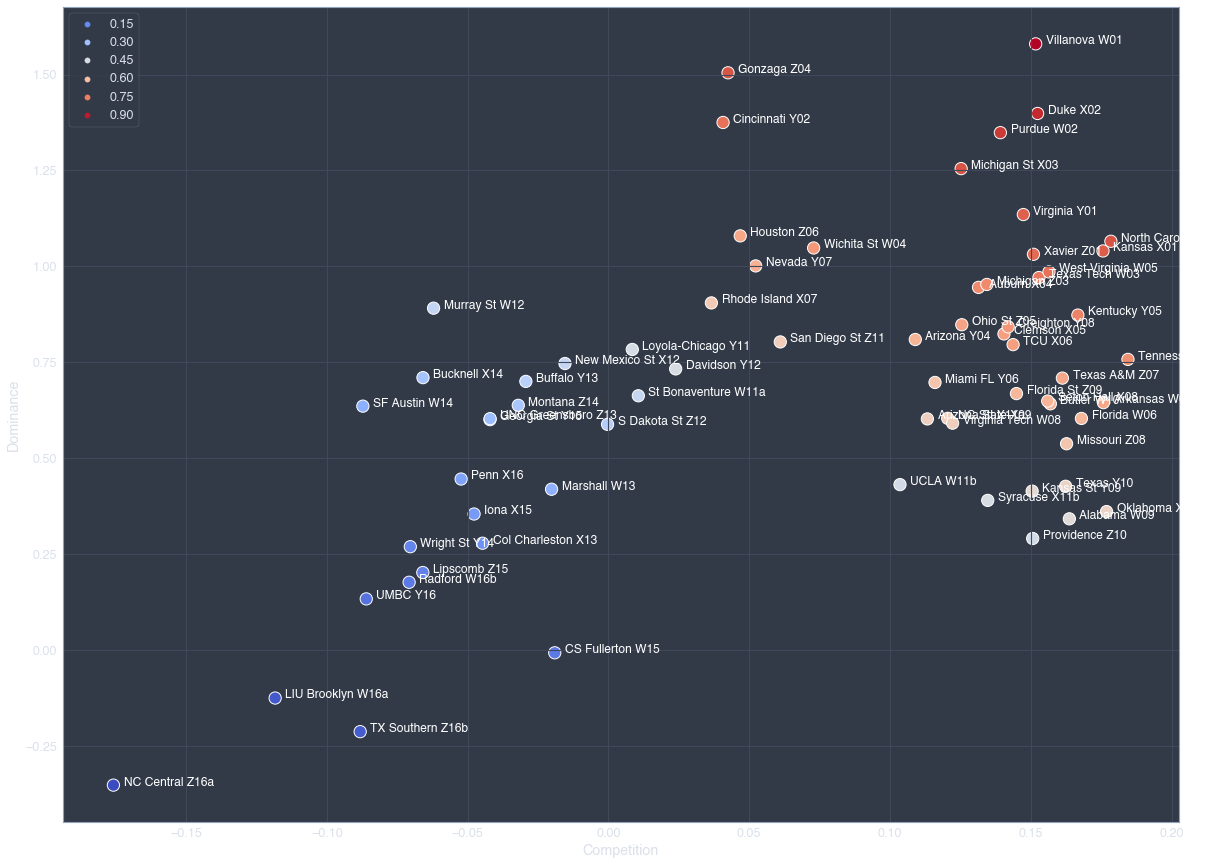

In [20]:
plt.figure(figsize=(20,15));
scatter_text(
    x=tournament_df["Competition"],
    y=tournament_df["Dominance"],
    hue=tournament_df["PowerRating"],
    palette=sns.color_palette("coolwarm", as_cmap=True),
    labelseries=tournament_df["TeamName"] + " " + tournament_df["Seed"],
    labelcolor="white",
    s=150,
);
plt.legend(loc='upper left');

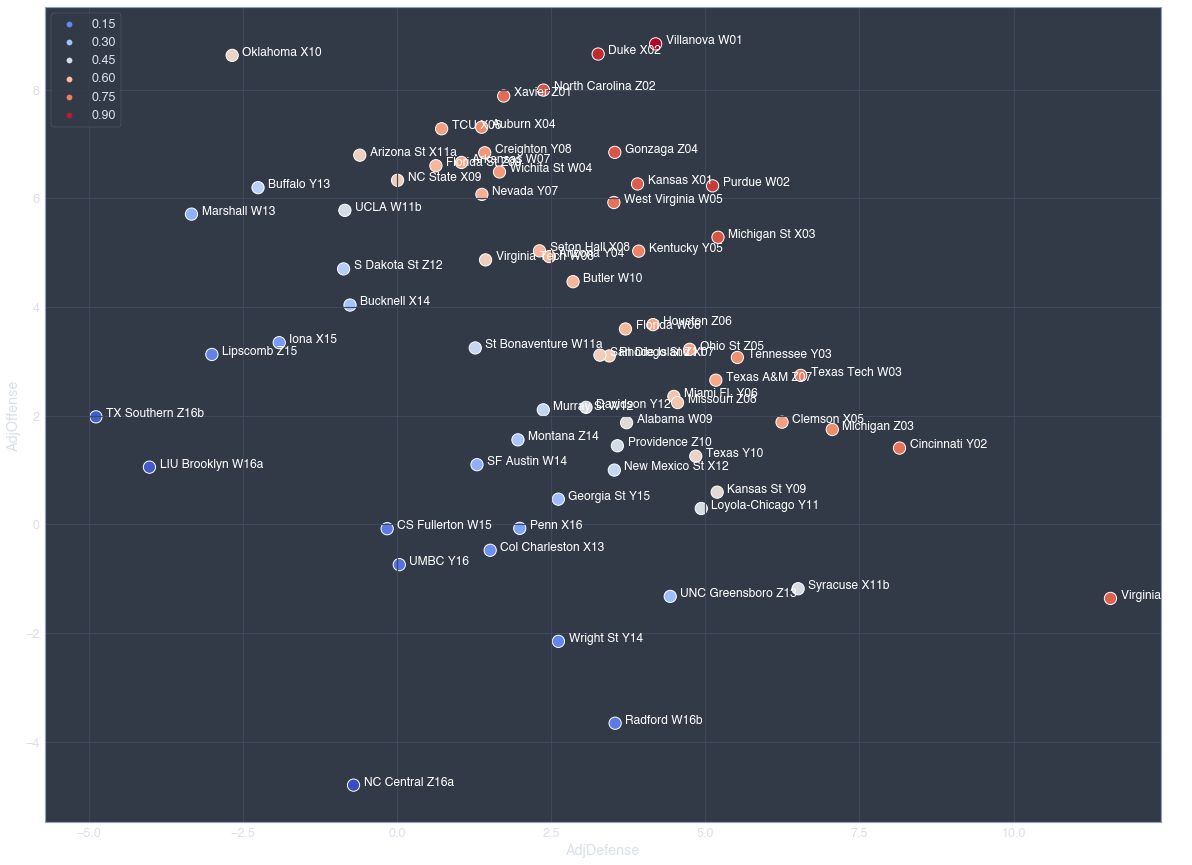

In [21]:
plt.figure(figsize=(20,15));
scatter_text(
    x=tournament_df["AdjDefense"],
    y=tournament_df["AdjOffense"],
    hue=tournament_df["PowerRating"],
    palette=sns.color_palette("coolwarm", as_cmap=True),
    labelseries=tournament_df["TeamName"] + " " + tournament_df["Seed"],
    labelcolor="white",
    s=150,
);
plt.legend(loc='upper left');

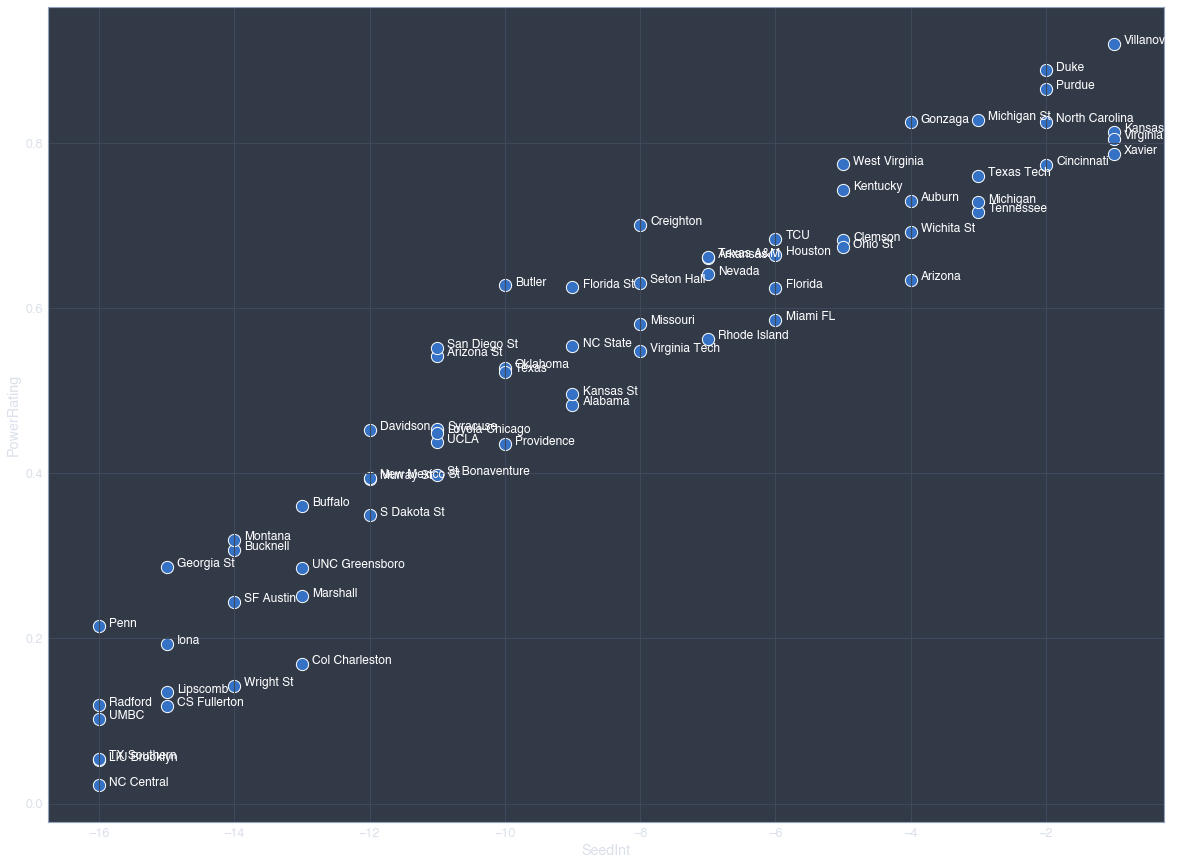

In [22]:
plt.figure(figsize=(20,15));
scatter_text(
    x=-simulation_df["SeedInt"],
    y=simulation_df["PowerRating"],
    s=150, labelseries=simulation_df["TeamName"], labelcolor="white",
);

In [23]:
BASIC_COLUMNS = [
    "TeamName", "Seed", "MeanWins",
    "PercentElite8", "PercentFinal4", "PercentChampion", "FairMoneyChampion"
]

In [24]:
# Who is the best team?
simulation_df.sort_values("PowerRating", ascending=False)[["PowerRating"] + BASIC_COLUMNS][:30]

,PowerRating,TeamName,Seed,MeanWins,PercentElite8,PercentFinal4,PercentChampion,FairMoneyChampion
8,0.920044,Villanova,W01,3.7810,0.7294,0.5202,0.2759,262.0
24,0.888232,Duke,X02,3.1830,0.5775,0.4164,0.1517,559.0
9,0.865686,Purdue,W02,2.7989,0.5622,0.2578,0.0913,995.0
26,0.828110,Michigan St,X03,2.1752,0.2979,0.1844,0.0380,2532.0
54,0.825848,North Carolina,Z02,2.7065,0.4860,0.2882,0.0717,1295.0
58,0.824892,Gonzaga,Z04,2.4474,0.4160,0.2429,0.0608,1545.0
22,0.813758,Kansas,X01,2.4123,0.4617,0.1958,0.0390,2464.0
37,0.805379,Virginia,Y01,2.5500,0.4386,0.2713,0.0524,1808.0
53,0.787041,Xavier,Z01,2.3686,0.3541,0.1872,0.0392,2451.0
15,0.774340,West Virginia,W05,1.6691,0.1598,0.0740,0.0154,6394.0


In [25]:
# Who has the easiest schedule on average (excluding play ins)
is_not_play_in =  ~simulation_df["Seed"].str[-1].apply(str.isalpha)
simulation_df[is_not_play_in].sort_values(
    "AvgOppPower", ascending=True)[["AvgOppPower"] + BASIC_COLUMNS][:16]

,AvgOppPower,TeamName,Seed,MeanWins,PercentElite8,PercentFinal4,PercentChampion,FairMoneyChampion
41,0.482314,Tennessee,Y03,2.1299,0.3222,0.1529,0.0179,5487.0
53,0.499915,Xavier,Z01,2.3686,0.3541,0.1872,0.0392,2451.0
28,0.514215,Auburn,X04,1.8706,0.2535,0.0856,0.0111,8909.0
37,0.518051,Virginia,Y01,2.5500,0.4386,0.2713,0.0524,1808.0
54,0.530819,North Carolina,Z02,2.7065,0.4860,0.2882,0.0717,1295.0
11,0.542664,Texas Tech,W03,1.9102,0.2515,0.0761,0.0150,6567.0
39,0.547491,Cincinnati,Y02,2.2282,0.3873,0.2091,0.0329,2940.0
13,0.552228,Wichita St,W04,1.3884,0.0805,0.0293,0.0038,26216.0
43,0.553613,Arizona,Y04,1.2743,0.1197,0.0516,0.0033,30203.0
22,0.555548,Kansas,X01,2.4123,0.4617,0.1958,0.0390,2464.0


In [26]:
# Who has the best chance to win
pie_df = simulation_df.sort_values("PercentChampion", ascending=False)
pie_df[[
    "TeamName", "Seed", "PowerRating", "AvgOppPower",
    "PercentElite8", "PercentFinal4", "PercentChampion", "FairMoneyChampion"
]][:10]

,TeamName,Seed,PowerRating,AvgOppPower,PercentElite8,PercentFinal4,PercentChampion,FairMoneyChampion
8,Villanova,W01,0.920044,0.565113,0.7294,0.5202,0.2759,262.0
24,Duke,X02,0.888232,0.577166,0.5775,0.4164,0.1517,559.0
9,Purdue,W02,0.865686,0.562298,0.5622,0.2578,0.0913,995.0
54,North Carolina,Z02,0.825848,0.530819,0.4860,0.2882,0.0717,1295.0
58,Gonzaga,Z04,0.824892,0.573709,0.4160,0.2429,0.0608,1545.0
37,Virginia,Y01,0.805379,0.518051,0.4386,0.2713,0.0524,1808.0
53,Xavier,Z01,0.787041,0.499915,0.3541,0.1872,0.0392,2451.0
22,Kansas,X01,0.813758,0.555548,0.4617,0.1958,0.0390,2464.0
26,Michigan St,X03,0.828110,0.597897,0.2979,0.1844,0.0380,2532.0
39,Cincinnati,Y02,0.773752,0.547491,0.3873,0.2091,0.0329,2940.0


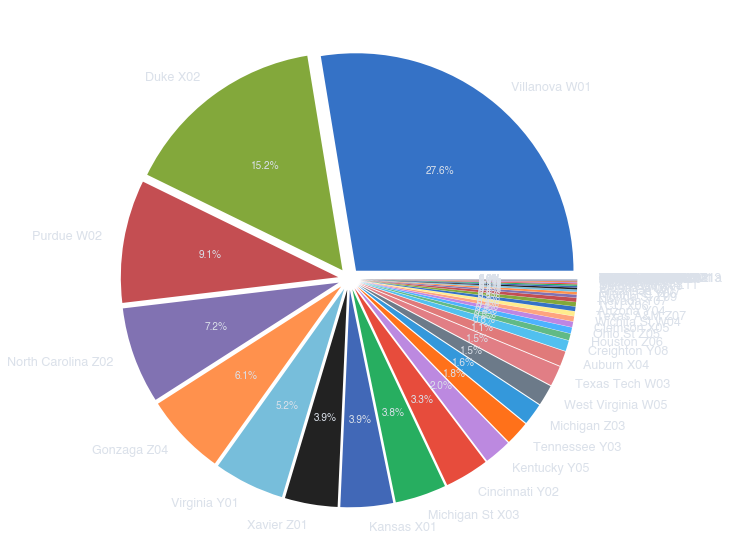

In [27]:
plt.figure(figsize=(10,10));
plt.pie(
    x=pie_df["PercentChampion"],
    labels=pie_df["TeamName"] + " " + pie_df["Seed"],
    autopct="%.1f%%",
    explode=[0.05]*len(simulation_df),
);

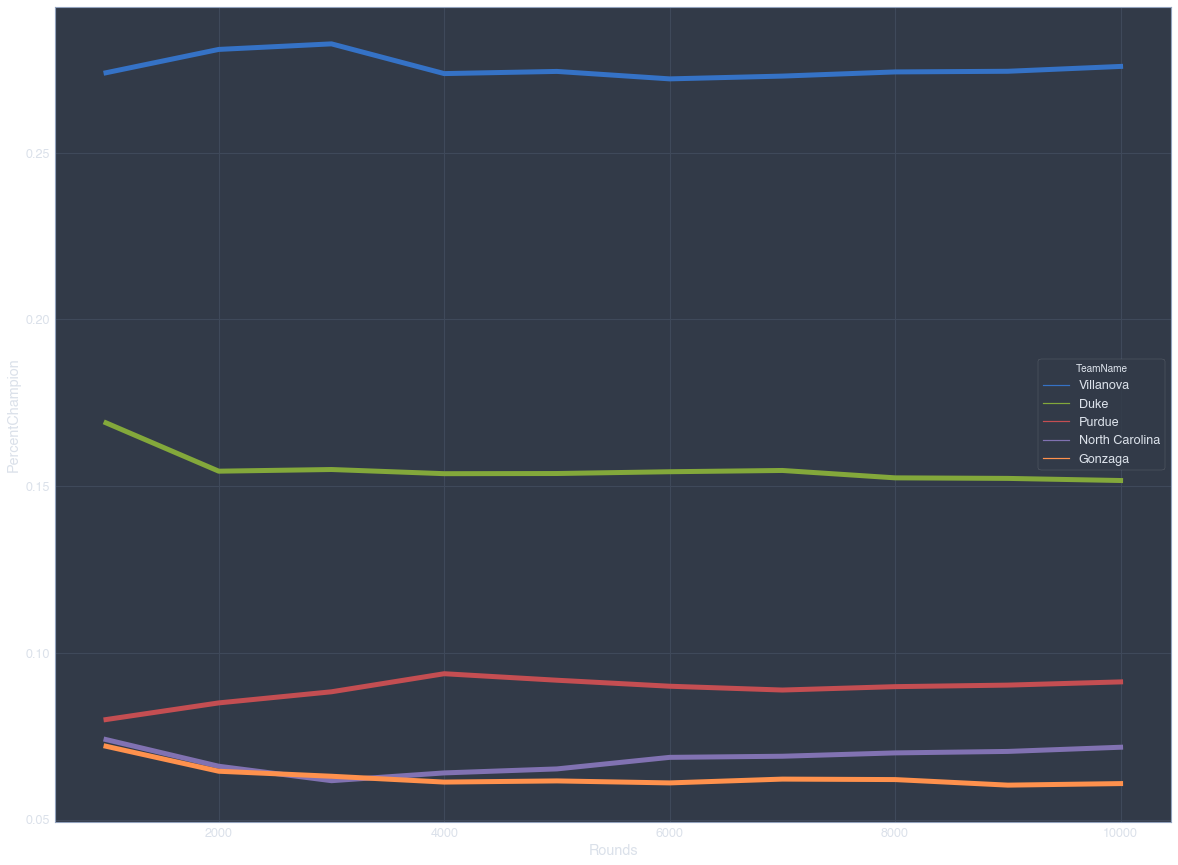

In [28]:
# Confirm % looks stable over time
plt.figure(figsize=(20,15));
progression_df = pd.DataFrame(simulation_progression).merge(
    tournament_df[["TeamID", "TeamName"]], on="TeamID"
)
sns.lineplot(
    data=progression_df,
    x="Rounds", y="PercentChampion", hue="TeamName", linewidth=5
);

In [29]:
 # What is the most common bracket?
bracket_slots = []
for slot, win_dict in slots_wins.items():
    top_teams = sorted(((v, k) for k, v in win_dict.items()), reverse=True)
    max_count, max_team_id = top_teams[0]
    runner_count, runner_team_id = top_teams[1]
    total = sum(v for v in win_dict.values())
    bracket_slots.append({
        "Slot": slot,
        "WinTeamID": max_team_id,
        "WinPct": max_count / total,
        "RunnerTeamID": runner_team_id,
        "RunnerWinPct": runner_count / total,
    })

bracket_df = pd.DataFrame(bracket_slots).merge(
    tournament_df[["TeamID", "TeamName", "Seed"]], left_on="WinTeamID", right_on="TeamID"
).rename(columns={"TeamName": "WinTeamName", "Seed": "WinSeed"}).merge(
    tournament_df[["TeamID", "TeamName", "Seed"]], left_on="RunnerTeamID", right_on="TeamID"
).rename(columns={"TeamName": "RunnerTeamName", "Seed": "RunnerSeed"})
bracket_df["Round"] = bracket_df["Slot"].apply(lambda x: int(x[1]) if x.startswith("R") else 0)
bracket_df = bracket_df[[
    "Slot", "Round",
    "WinTeamName", "WinSeed", "WinPct",
    "RunnerTeamName", "RunnerSeed", "RunnerWinPct"
]]

In [30]:
bracket_df[bracket_df["Round"] == 5].sort_values("WinPct", ascending=False)

,Slot,Round,WinTeamName,WinSeed,WinPct,RunnerTeamName,RunnerSeed,RunnerWinPct
8,R5WX,5,Villanova,W01,0.3600,Duke,X02,0.2190
57,R5YZ,5,North Carolina,Z02,0.1777,Gonzaga,Z04,0.1483


In [31]:
# Submit to Kaggle
import itertools
predictions = []
vegas = []
for year in range(2015, 2020):
    submit_df = raw_tournament_df[raw_tournament_df["Season"] == year].set_index(["Season", "TeamID"])
    ids = sorted(submit_df.loc[year].index)
    for id_a, id_b in itertools.product(ids, ids):
        if id_a >= id_b:
            continue
        team_a = submit_df.loc[(year, id_a)]
        team_b = submit_df.loc[(year, id_b)]
        predict_data = (
            team_a["AdjOffense"], team_b["AdjOffense"],
            team_a["AdjDefense"], team_b["AdjDefense"],
        )
        prob = calc_prob(predict_data)
        predictions.append({
            "ID": f"{year}_{id_a}_{id_b}",
            "Pred": prob
        })
        if year == YEAR:
            favorite = team_a["TeamName"] if prob > .5 else team_b["TeamName"]
            prob = max(prob, 1 - prob)
            vegas.append({
                "TeamA": team_a["TeamName"],
                "TeamB": team_b["TeamName"],
                "Favorite": favorite,
                "Prob": prob,
                "FairMoney": round(100 * prob / (1 - prob)),
            })

In [32]:
pred_df = pd.DataFrame(predictions)
pred_df.to_csv(f"{DATA_DIR}/output/kaggle_submission.csv", index=False)

In [33]:
vegas_df = pd.DataFrame(vegas).set_index(["TeamA", "TeamB"])

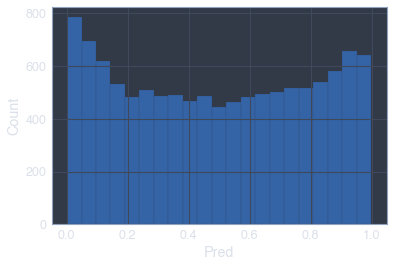

In [34]:
sns.histplot(pred_df["Pred"], color='b');

In [35]:
set(vegas_df.index.get_level_values(0))

{'Alabama',
 'Arizona',
 'Arizona St',
 'Arkansas',
 'Auburn',
 'Bucknell',
 'Buffalo',
 'Butler',
 'CS Fullerton',
 'Cincinnati',
 'Clemson',
 'Col Charleston',
 'Creighton',
 'Davidson',
 'Duke',
 'Florida',
 'Florida St',
 'Georgia St',
 'Gonzaga',
 'Houston',
 'Iona',
 'Kansas',
 'Kansas St',
 'Kentucky',
 'LIU Brooklyn',
 'Lipscomb',
 'Loyola-Chicago',
 'Marshall',
 'Miami FL',
 'Michigan',
 'Michigan St',
 'Missouri',
 'Montana',
 'Murray St',
 'NC Central',
 'NC State',
 'Nevada',
 'New Mexico St',
 'North Carolina',
 'Ohio St',
 'Oklahoma',
 'Penn',
 'Providence',
 'Purdue',
 'Radford',
 'Rhode Island',
 'S Dakota St',
 'SF Austin',
 'San Diego St',
 'Seton Hall',
 'St Bonaventure',
 'Syracuse',
 'TCU',
 'TX Southern',
 'Tennessee',
 'Texas',
 'Texas A&M',
 'Texas Tech',
 'UCLA',
 'UMBC',
 'UNC Greensboro',
 'Villanova',
 'Virginia',
 'Virginia Tech',
 'West Virginia',
 'Wichita St',
 'Wright St'}

In [37]:
vegas_df.loc[("UMBC", "Virginia")]

Favorite     Virginia
Prob         0.973551
FairMoney        3681
Name: (UMBC, Virginia), dtype: object